# How Seattle's Budget Affects Crime Rate 

Note: Tableau visualizations may not be visible on github. Here is a link to all the visualizations: https://public.tableau.com/profile/nick.kouthong#!/

Seattle is a bustling and diverse city that continues to innovate in response to its dynamic demographic. In this report I aim to analyze how Seattle's decisions on budgeting affect the rate of crime in the city.

First, let us gather the necessary libraries for our analysis. 

In [122]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [123]:
finance2017 = pd.read_csv("2018_Proposed_Budget_Dollars.csv")
finance2016 = pd.read_csv("2016_Adopted_Budget_Dollars.csv")
crime = pd.read_csv("Crime_Data.csv")

The features included in these csv files include the actual, adopted, and endorsed budget value for a specific year. The adopted and endorsed values are maluable meaning they can change before the final implementation. The actual budge value is the final budget implemented that year. To get the most accurate picture of how the budget split effects the city, we will use the actuals values from the previous years for any predictive tasks. Specifically, we have the actuals for 2015 and 2016.

In [124]:
finance2016.head()

,DeptCode,BCLName,ProgramName,2015 Actual,2015 Adopted,2016 Endorsed,2016 Adopted
0,12LIBLEVY,Library Levy Operating Transfer,Library Levy Operating Transfer,12560843.0,13139976.0,13665837.0,13665837.0
1,ARTS,Arts Account,Administrative Services,535825.0,652869.0,577473.0,598187.0
2,ARTS,Arts Account,Community Development and Outreach,537298.0,616223.0,624749.0,611425.0
3,ARTS,Arts Account,Cultural Partnerships,3480285.0,3810876.0,3766536.0,4517092.0
4,ARTS,Arts Account,Langston Hughes Performing Arts Institute,824622.0,875117.0,843873.0,428046.0


In [125]:
finance2017.head()

,DeptCode,BCLName,ProgramName,2016 Actuals,2017 Adopted,2018 Endorsed,2018 Proposed
0,12LIBLEVY,Library Levy Operating Transfer,Library Levy Operating Transfer,16416248.0,14503161,14905762,15406132
1,ARTS,Municipal Arts Fund,Artwork Conservation,167028.0,192527,195486,196788
2,CBLFEE,Cable Fee Support to Information Technology Fund,Applications,0.0,742062,430062,430062
3,CBLFEE,Cable Fee Support to Information Technology Fund,Business Office,238440.0,456822,386145,386145
4,CBLFEE,Cable Fee Support to Information Technology Fund,Citywide Web Team,1105252.0,1122959,1135302,1135302


In [126]:
crime.head()

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
0,20190000905007,05/06/2019,1800.0,05/07/2019,1008.0,CAR PROWL,THEFT-CARPROWL,NORTH,J,J3,PHINNEY RIDGE
1,20190000905022,04/25/2019,2100.0,05/07/2019,1407.0,THEFT-BUILDING,THEFT-BUILDING,WEST,D,D3,SLU/CASCADE
2,20190000162679,04/12/2019,1.0,05/07/2019,122.0,THEFT-ALL OTHER,THEFT-OTH,SOUTHWEST,F,F1,NORTH DELRIDGE
3,20190000162720,05/07/2019,149.0,05/07/2019,149.0,DUI,DUI-DRUGS,EAST,E,E3,CAPITOL HILL
4,20190000904999,05/05/2019,1230.0,05/07/2019,839.0,THEFT-BUILDING,THEFT-BUILDING,WEST,D,D2,SLU/CASCADE


# Data Cleaning

Before we move on ahead let us clean the data real quick. There are a few things we have to deal with, potential missing data, potential duplicate data and those white spaces in the column names.

In [127]:
finance2016.shape

(723, 7)

In [128]:
finance2016.isnull().sum()

DeptCode         0
BCLName          0
ProgramName      0
2015 Actual      3
2015 Adopted     6
2016 Endorsed    6
2016 Adopted     5
dtype: int64

Next we check if there are any duplicate rows.

In [129]:
duplicates2016 = finance2016[finance2016.duplicated()]
len(duplicates2016)

0

In [130]:
finance2016 = finance2016.rename(index = str, columns = {'2015 Actual': '2015_Actual', '2015 Adopted': '2015_Adopted',
                                                        '2016 Endorsed':'2016_Endorsed','2016 Adopted':'2016_Adopted'})
finance2016.columns

Index(['DeptCode', 'BCLName', 'ProgramName', '2015_Actual', '2015_Adopted',
       '2016_Endorsed', '2016_Adopted'],
      dtype='object')

We are in good shape for the 2016 table. Let's repeat the process for the two other datasets. 

In [131]:
finance2017.shape

(579, 7)

In [132]:
finance2017.isnull().sum()

DeptCode         0
BCLName          0
ProgramName      0
2016 Actuals     0
2017 Adopted     0
2018 Endorsed    0
2018 Proposed    0
dtype: int64

In [133]:
duplicates2017 = finance2017[finance2017.duplicated()]
len(duplicates2017)

0

In [134]:
finance2017 = finance2017.rename(index = str, columns = {'2016 Actuals': '2016_Actuals', '2017 Adopted':'2017_Adopted',
                                                        '2018 Endorsed': '2018_Endorsed', '2018 Proposed':'2018_Proposed'})
finance2017.columns

Index(['DeptCode', 'BCLName', 'ProgramName', '2016_Actuals', '2017_Adopted',
       '2018_Endorsed', '2018_Proposed'],
      dtype='object')

In [135]:
crime.shape

(523590, 11)

In [136]:
crime.isnull().sum()

Report Number                     0
Occurred Date                     2
Occurred Time                     2
Reported Date                     0
Reported Time                     2
Crime Subcategory               262
Primary Offense Description       0
Precinct                          6
Sector                         3346
Beat                           3298
Neighborhood                      0
dtype: int64

In [137]:
duplicates_crime = crime[crime.duplicated()]
len(duplicates_crime)

0

In [138]:
crime = crime.rename(index = str, 
                     columns = {'Report Number': 'Report_Number','Occurred Date': 'Occurred_Date','Occurred Time': 'Occurred_Time',
                               'Reported Date': 'Reported_Date', 'Reported Time':'Reported_Time', 
                                'Crime Subcategory': 'Crime_Subcategory',
                                'Primary Offense Description':'Primary_Offense_Description'})
crime.columns

Index(['Report_Number', 'Occurred_Date', 'Occurred_Time', 'Reported_Date',
       'Reported_Time', 'Crime_Subcategory', 'Primary_Offense_Description',
       'Precinct', 'Sector', 'Beat', 'Neighborhood'],
      dtype='object')

In [139]:
import dateutil.parser as parser
count = 0
#for x in range(len(crime['Occurred_Date'])):
    #if parser.parse(crime['Occurred_Date'][x]).year == 2015:
        #count += 1
#count
#parser.parse(crime['Occurred_Date'][0]).year
crime

,Report_Number,Occurred_Date,Occurred_Time,Reported_Date,Reported_Time,Crime_Subcategory,Primary_Offense_Description,Precinct,Sector,Beat,Neighborhood
0,20190000905007,05/06/2019,1800.0,05/07/2019,1008.0,CAR PROWL,THEFT-CARPROWL,NORTH,J,J3,PHINNEY RIDGE
1,20190000905022,04/25/2019,2100.0,05/07/2019,1407.0,THEFT-BUILDING,THEFT-BUILDING,WEST,D,D3,SLU/CASCADE
2,20190000162679,04/12/2019,1.0,05/07/2019,122.0,THEFT-ALL OTHER,THEFT-OTH,SOUTHWEST,F,F1,NORTH DELRIDGE
3,20190000162720,05/07/2019,149.0,05/07/2019,149.0,DUI,DUI-DRUGS,EAST,E,E3,CAPITOL HILL
4,20190000904999,05/05/2019,1230.0,05/07/2019,839.0,THEFT-BUILDING,THEFT-BUILDING,WEST,D,D2,SLU/CASCADE
5,20190000905012,05/06/2019,1105.0,05/07/2019,1125.0,CAR PROWL,THEFT-CARPROWL,NORTH,N,N3,GREENWOOD
6,20190000905020,04/30/2019,1520.0,05/07/2019,1325.0,CAR PROWL,THEFT-CARPROWL,WEST,K,K1,DOWNTOWN COMMERCIAL
7,20190000905003,05/07/2019,510.0,05/07/2019,936.0,CAR PROWL,THEFT-CARPROWL,WEST,K,K1,DOWNTOWN COMMERCIAL
8,20190000905015,05/04/2019,900.0,05/07/2019,1140.0,THEFT-ALL OTHER,THEFT-MAIL,NORTH,L,L2,NORTHGATE
9,20190000905023,05/05/2019,1400.0,05/07/2019,1426.0,THEFT-ALL OTHER,THEFT-OTH,SOUTHWEST,F,F1,PIGEON POINT


# Data Exploration

A side note: Most of the visualizations for this project will be done in Tableau for a more pleasing and interactive presentation. 

Let us begin by diving into the data. I will use the visuals along the way to come up with with hypotheses to test out in a later section. 

Let us first see how the 2015 and 2016 actuals were distributed among the deparments. 

In [140]:
%%HTML
<div class='tableauPlaceholder' id='viz1558632667204' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;Seattle2015Actuals&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Seattle2015Actuals&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;Seattle2015Actuals&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1558632667204');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

As we can see, general expenses recieved the largest cut of the 2015 budget. The other larger expenseses were focussed mainly on preservation and construction (Parks, Alaskan way Viaduct, Library fund). The Human Services Operating fund provides health and support care to various causes. Trauma care, community connections and senior centers just to name a few. (Source: http://www.seattle.gov/humanservices/funding-and-reports/funding-opportunities). 

Some notable programs that got little to no funding at all include: homeless shelter development, community engagement, and youth violance prevention. 

Next, let's see if the 2016 distribution has any significant changes. 

In [141]:
%%HTML
<div class='tableauPlaceholder' id='viz1558642786190' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;Seattle2016Actuals&#47;Dashboard2&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Seattle2016Actuals&#47;Dashboard2' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;Seattle2016Actuals&#47;Dashboard2&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1558642786190');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Comparing the two years, it's hard to see any significant difference in the data especially when it comes to programs related to preventing crime. To visualize the data for our purposes better, I will filter out the programs that are not directly related to crime and calculate the change in funding from 2015 to 2016. To do this I will simply calculate (2016 Actuals) - (2015 Actuals) to the program names I deem relavent to crime. Of course this will introduce some selection bias to our analysis but it will provide a more intuitive picture of the crime landscape.

In [142]:
%%HTML
<div class='tableauPlaceholder' id='viz1558643870820' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;SeattleCrimefundingdifferences&#47;Sheet5&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='SeattleCrimefundingdifferences&#47;Sheet5' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Se&#47;SeattleCrimefundingdifferences&#47;Sheet5&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1558643870820');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

From what we see here, it seems that in 2016 Seattle focussed its efforts towards revamping it justice and homeless policies hence the increased funding towards homeless intervention and the deparment of justice/police accountability programs. Surpisingly, funding towards programs that relate directly to crime prevention and the police took a hit. Noteably, emergency response, domestic violence detectives, narcotic investigations etc. 

We could argue that the decrease in funds to those crime fighting programs may be because the crime rate decreased in 2016. Let's take a look at that 

In [143]:
%%HTML
<div class='tableauPlaceholder' id='viz1558645821550' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cr&#47;Crimethroughouttheyears&#47;Sheet4&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Crimethroughouttheyears&#47;Sheet4' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cr&#47;Crimethroughouttheyears&#47;Sheet4&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1558645821550');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

If we look at the chart we can see that our earlier hypothesis was wrong and the number of crimes has been steadily increasing since 2015. We can ignore 2019 right now since the year has yet to be concluded at the time of this project.

In [144]:
%%HTML
<div class='tableauPlaceholder' id='viz1559158535837' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cr&#47;Crimethroughouttheyears&#47;Sheet5&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Crimethroughouttheyears&#47;Sheet5' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cr&#47;Crimethroughouttheyears&#47;Sheet5&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1559158535837');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

From the charts we see a 8% increase in crime from 2015 to 2018. 

In [145]:
%%HTML
<div class='tableauPlaceholder' id='viz1559668776899' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;20&#47;2018proposedvs2015actuals&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='2018proposedvs2015actuals&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;20&#47;2018proposedvs2015actuals&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1559668776899');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

I do not have the actual values for 2018 so I used the proposed values for that year. We can see an increase in funding to the crime prevention programs I filtered out. Yet, we still saw a steady increase in crime. Then is it safe to rule out that funding has little effect on with crime rate? Not quite yet.

# Statistical Tests

*T-Value Test*

We want to quantify the hypothesis that funding does affect crime rate. We will test this hypothesis against the null hypothesis of: funding does not affect crime rate. To do this we can conduct a t-test by using the scipy stats library. 

First lets filter the data we need.

In [146]:
number_of_crimes = [47668,49225,50423,51441]
programs = ['Police Relief and Pension Fund', 'Emergency Subfund',
           'Police Civilian Community Liason Services', 'Police Accountability Reserve',
           'Emergency Homeless Program', 'Emergency Response', 
           'Gun violence Prevention Program', 'Jail Services','Alcohol and Other Drugs',
           'Office of the Community Police Commission', 'Narcotics Investigations',
           'Police Action Expenses', 'Youth Violence Prevention Initiative', 
           'Homeless Intervention', 
            'Department of Justic Settlement Agreement Public Safety Reserve']
crime15 = finance2016[finance2016['ProgramName'].isin(programs)]
crime16 = finance2017[finance2017['ProgramName'].isin(programs)]
sum15 = crime15['2015_Actual'].sum()
sum16 = crime16['2016_Actuals'].sum()
sum17 = crime16['2017_Adopted'].sum()
sum18 = crime16['2018_Proposed'].sum()
years = [2015,2016,2017,2018]
spending_on_crime = [int(sum15),int(sum16),int(sum17),int(sum18)]

Text(0.5, 1.0, 'Spending amount on Crime. 2015 through 2018 ')

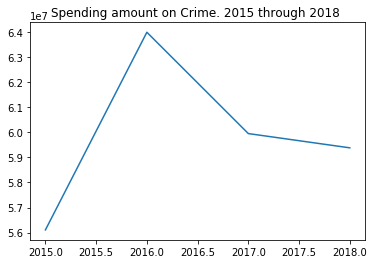

In [147]:
sns.lineplot(x = years, y = spending_on_crime).set_title('Spending amount on Crime. 2015 through 2018 ')

Text(0.5, 1.0, 'Number of Crimes Per Year Vs. Budget Spent on Crime')

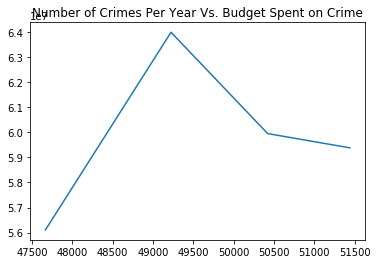

In [199]:
sns.lineplot(x = number_of_crimes, y = spending_on_crime).set_title('Number of Crimes Per Year Vs. Budget Spent on Crime')

In [197]:
from scipy import stats
from scipy.stats import norm
crime_num = np.asarray(number_of_crimes)
spend_num = np.asarray(spending_on_crime)
var_crime = crime_num.var(ddof = 1)
var_spend = spend_num.var(ddof = 1)
var_crime == var_spend

False

In [161]:
def s2_statistic(array):
    num_sum = 0;
    for x in range(len(array)):
        num_sum += (array[x] - array.mean()) **2
    return  num_sum / (len(array) - 1)   
        

In [186]:
import math
def t_test(array1, array2, s1,s2):
    nume = array1.mean() - array2.mean()
    denom = math.sqrt(((s2 ** 2) / len(array2)) + ((s1**2) / len(array1)))
    return nume / denom

In [196]:
t2,p2 = stats.ttest_ind(crime_num,spend_num, equal_var = False)
print('t-Statistic:', t2)
print('p-value:', p2)

t-Statistic: -36.96684223769834
p-value: 4.354005747565469e-05


The p-value is extremely low. This means that there is only a rougly 0.0001% chance that this pattern happened by chance. Thus we can reject the null hypothesis and state that Seattle's budget spending does indeed have a statistically significant affect on crime rates. 

In [150]:
 from scipy.interpolate import interp1d

In [209]:
lin_interp = interp1d(number_of_crimes,spending_on_crime)

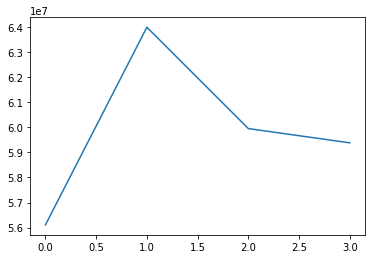

In [210]:
plt.plot(lin_interp(number_of_crimes))
#plt.plot(number_of_crimes,spending_on_crime)